In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.layers import NumericalMarkowitz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os
from deepdow.layers import Conv
from deepdow.layers.collapse import AttentionCollapse, AverageCollapse
from deepdow.layers.misc import CovarianceMatrix

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 | packaged by conda-forge | (main, Mar  3 2025, 20:43:55) [GCC 13.3.0].


In [2]:
import pandas as pd
df = pd.read_parquet('df.parquet')

In [3]:
#df = raw_df[-300:]
df


Ticker            AAPL                                                  \
Price            Close        High         Low        Open      Volume   
Date                                                                     
2006-03-27    1.790870    1.847145    1.787560    1.816148  1108072000   
2006-03-28    1.766796    1.809829    1.752952    1.794481  1370322800   
2006-03-29    1.875734    1.881452    1.735498    1.779435  2346834000   
2006-03-30    1.888373    1.904924    1.851659    1.890479  1390650800   
2006-03-31    1.887471    1.914254    1.873026    1.903421   815357200   
...                ...         ...         ...         ...         ...   
2025-03-20  214.100006  217.490005  212.220001  213.990005    48862900   
2025-03-21  218.270004  218.839996  211.279999  211.559998    94127800   
2025-03-24  220.729996  221.479996  218.580002  221.000000    44299500   
2025-03-25  223.750000  224.100006  220.080002  220.770004    34493600   
2025-03-26  221.529999  225.020004  220.470001  223.509995    34466100   

Ticker            AMGN                                               ...  \
Price            Close        High         Low        Open   Volume  ...   
Date                                                                 ...   
2006-03-27   50.995205   51.176585   50.409216   50.751043  5824900  ...   
2006-03-28   50.653378   51.497484   50.402238   51.218439  9298900  ...   
2006-03-29   50.241776   51.030077   50.095278   50.667317  6687100  ...   
2006-03-30   50.660351   51.148675   50.311546   50.332474  7623500  ...   
2006-03-31   50.751030   51.169594   50.688248   50.848695  8828100  ...   
...                ...         ...         ...         ...      ...  ...   
2025-03-20  315.040009  315.989990  312.239990  314.179993  2049700  ...   
2025-03-21  316.040009  316.489990  311.160004  311.820007  9995000  ...   
2025-03-24  314.380005  317.579987  313.429993  315.000000  2439400  ...   
2025-03-25  306.859985  314.220001  303.510010  313.980011  2565300  ...   
2025-03-26  305.709991  309.089996  304.350006  306.440002  2375200  ...   

Ticker            WBA                                                   WMT  \
Price           Close       High        Low       Open    Volume      Close   
Date                                                                          
2006-03-27  26.269537  26.292878  25.732708  25.919431   4527400  10.771452   
2006-03-28  25.645187  26.111994  25.417620  26.053644   5734800  10.726527   
2006-03-29  25.674360  25.872753  25.633515  25.732710   3052700  10.793917   
2006-03-30  25.394274  25.721039  25.306747  25.569326   3189000  10.706310   
2006-03-31  25.166706  25.557655  25.108354  25.405944   3325900  10.611959   
...               ...        ...        ...        ...       ...        ...   
2025-03-20  11.120000  11.200000  11.120000  11.160000  12048300  85.574997   
2025-03-21  11.100000  11.190000  11.080000  11.110000  37249800  85.980003   
2025-03-24  11.150000  11.150000  11.090000  11.120000  12137700  87.489998   
2025-03-25  11.120000  11.170000  11.120000  11.150000   7945800  84.760002   
2025-03-26  11.100000  11.150000  11.100000  11.120000   9880500  85.209999   

Ticker                                                 
Price            High        Low       Open    Volume  
Date                                                   
2006-03-27  10.850076  10.760221  10.825366  25991400  
2006-03-28  10.854571  10.706310  10.771454  30132900  
2006-03-29  10.823120  10.670365  10.737757  26045400  
2006-03-30  10.823122  10.627686  10.793919  29380800  
2006-03-31  10.769206  10.602973  10.769206  30273000  
...               ...        ...        ...       ...  
2025-03-20  86.841523  85.285790  85.574997  18185500  
2025-03-21  86.230003  84.779999  85.279999  26797200  
2025-03-24  87.650002  86.349998  86.470001  17900700  
2025-03-25  87.309998  84.620003  86.760002  27908600  
2025-03-26  85.559998  84.570000  85.190002  27228800  

[4781 

In [4]:
horizon_len = 7
patch_len = 32
patch_num = 20
batch_size = 32
hidden_size = 128
channels = ['Close', 'Volume'] #['Close', 'High','Low',	'Open',	'Volume']

In [5]:
def get_model(load_weights: bool = False, horizon_len: int = 7):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=horizon_len,
      num_layers=50,
      use_positional_embedding=False,
      context_len=2048,  # Context length can be anything up to 2048 in multiples of 32
      input_patch_len=patch_len
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

  model = PatchedTimeSeriesDecoder(tfm._model_config)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config

In [6]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10

# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

In [7]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (4286, 5, 640, 30), y: (4286, 5, 30, 30)


In [8]:
n_samples

4110

In [9]:
split_ix = int(n_samples * 0.95)
indices_train = list(range(split_ix))
#indices_test = list(range(split_ix + lookback + horizon, n_samples))
indices_test = list(range(split_ix + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:3903
Test range: 3934:4109


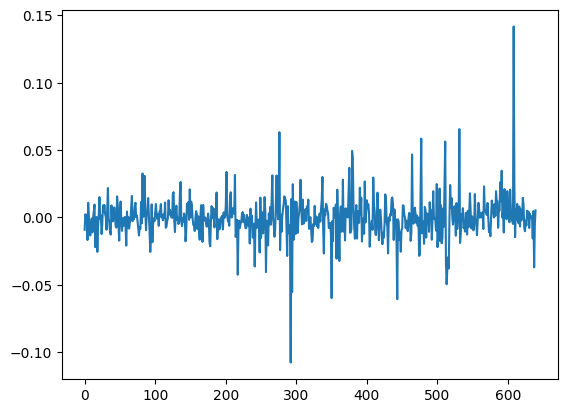

In [10]:
plt.plot(X[1, 1, :, 1])

In [11]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [ 0.00041615  0.00041877  0.0004205   0.00042053 -0.00024219], std: [0.01774467 0.0150831  0.01676391 0.01743764 0.34207168]


In [12]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

In [13]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

In [14]:
device = 'cuda'

In [15]:
sfm_model, a, b = get_model(load_weights=True)
sfm_model.to('cuda')

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

PatchedTimeSeriesDecoder(
  (input_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=64, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
  )
  (freq_emb): Embedding(3, 1280)
  (horizon_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=1280, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (stacked_transformer): StackedDecoder(
    (layers): ModuleList(
      (0-49): 50 x TimesFMDecoderLayer(
        (self_attn): TimesFMAttention(
          (qkv_proj): Linear(in_features=1280, out_features=3840, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (

In [28]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
#n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, g_timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10
n_assets = len(asset_names)
# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

In [9]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (4309, 2, 640, 30), y: (4309, 2, 7, 30)


In [10]:
n_samples

4133

In [11]:
split_ix = int(n_samples * 0.975)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:4028
Test range: 4036:4132


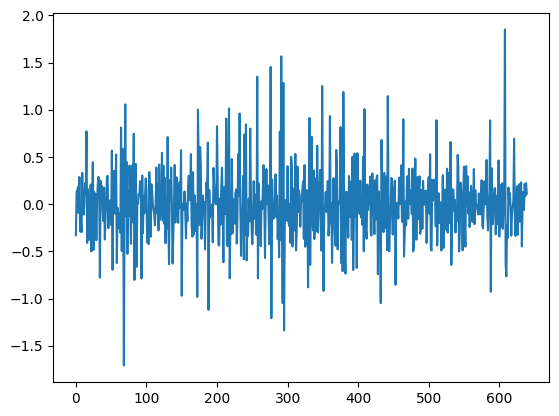

In [12]:
plt.plot(X[1, 1, :, 1])

In [13]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [ 0.00043403 -0.00022286], std: [0.01764646 0.3423143 ]


In [14]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

In [15]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

In [16]:
device = 'cuda'

In [17]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.1, max_weight=1., n_output_channels = 4):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        
     
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        layers = []

        layers.append(nn.Linear(channels, 1))
        layers.append(nn.ReLU())
        self.CollapseChannel = nn.Sequential(*layers)
        
        # self.CollapseSFM = Conv(n_input_channels=n_features,
        #      n_output_channels=hidden_size,
        #      kernel_size=3,
        #      method='1D')
        
        # self.CollapseSFM_2 = Conv(n_input_channels=hidden_size,
        #      n_output_channels=1,
        #      kernel_size=3,
        #      method='1D')
        # 参数
        d_model = 128  # 隐藏维度
        nhead = 8      # 注意力头数
        num_encoder_layers = 6  # 编码器层数
        num_decoder_layers = 6  # 解码器层数
        dim_feedforward = 2048  # 前馈层中间维度
        self.decode_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=p,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=0.5)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, channels, lookback, n_assets = x.shape
        # x = x.permute(0, 3, 1, 2)
        # x = x.reshape(n_samples, n_assets*channels, -1) 
        with torch.no_grad():
            xx_list = []
            for i in range(channels):
                xx = x[:,i,:,:].squeeze(1)
                xx = xx.permute(0, 2, 1)
                xx = xx.contiguous()
                input_padding = torch.zeros_like(xx).to(device)
                freq = torch.tensor([0], dtype=torch.long).to(device)
                xx = sfm_model(xx, input_padding, freq)
                xx = xx[:,:,:,5]
                #xx = xx.squeeze(2)
                #xx = xx.unsqueeze(1) # B, 1, n_assets*patch_num, 128
                
                xx_list.append(xx)
        x = self.decode_layer(xx)
        x = torch.cat(xx_list, dim=1) # B, channels, n_assets*patch_num, 128
        x = x.view(n_samples, channels, n_assets, patch_num*128)  # 
        x = x.permute(0,2,3,1) # B, n_assets, patch_num*128, channels,   ## B, channels, patch_num*128, n_assets
        #x = x.reshape(n_samples, n_assets, channels*patch_num*128) # B, n_assets, channels*patch_num*128
        x = self.CollapseChannel(x) # B,  n_assets,  patch_num*128, 1
        x = self.dropout_layer(x)
        x = x.squeeze(-1)
        

        x = self.CollapseSFM(x) # B,  n_assets,   1
        x = self.dropout_layer(x)
        
        # x = self.CollapseSFM_2(x)
        # x = self.dropout_layer(x)
        
        x = x.squeeze(-1)
        
        #x = self.dense_layer(x)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [17]:
from curses import meta

current_timestamps = None
class DeepCallback(Callback):
    def __init__(self, model, hparams, config):
        super().__init__()
        self.model = model
        self.hparams = hparams
        self.config = config
        self.embedding_layer = nn.Linear(5, 128)
    def on_batch_begin(self, metadata):
        global current_timestamps
        global g_timestamps
        timestamps = metadata['timestamps']
        
        features = [[ts.year, ts.month, ts.day, ts.hour, ts.minute] for ts in g_timestamps[timestamps]]
        current_timestamps = torch.tensor(features, dtype=torch.float32).to(device)
        current_timestamps = self.embedding_layer(current_timestamps)

        return 

In [30]:

from torch import dropout


class DeepNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.4, max_weight=1., n_output_channels = 4):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        
     
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        
        self.embedding_layer_2 = nn.Linear(n_assets*channels, n_assets*32, bias=True)
        self.embedding_layer_1 = nn.Linear(n_assets*channels, n_assets*32, bias=True)
        # 参数
        d_model = n_assets*32  # 隐藏维度
        nhead = 4      # 注意力头数
        num_encoder_layers = 4  # 编码器层数
        num_decoder_layers = 4  # 解码器层数
        dim_feedforward = 2048  # 前馈层中间维度
        dropout = 0.2
        self.encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(d_model//n_assets * lookback, 1, bias=True)
        self.dense_layer_2 = torch.nn.Linear(horizon_len*32, 1, bias=True)
        
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=1)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x):
        global current_timestamps
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, channels, lookback, n_assets = x.shape
        x = x.permute(0, 1, 3, 2)
        x = x.reshape(n_samples, channels*n_assets, lookback)
        m_list = [] 
        
        for i in range(n_samples):
            m = x[i, :,:]
            input_padding = torch.zeros_like(m).to(device)
            freq = torch.tensor([0], dtype=torch.long).to(device)
            with torch.no_grad():
                m = sfm_model(m, input_padding, freq) # B, patch_num, 128, 10 (mean +  9 quantiles)
            #m = sfm_model(m, input_padding, freq)
            m = m[:,:,:,0] # B, patch_num, 128
            m = m[:,-1,:] # B, 1, 128 last prediction
            m_list.append(m)
        m = torch.stack(m_list, dim=0) # B, channels*n_assets, 128
        m = m[:,:,0:horizon_len]
        m = m.permute(0,2,1) # B, horizon_len, channels*n_assets
        m = self.embedding_layer_1(m) # B, horizon_len, n_assets*32
    
        x = x.permute(0, 2, 1) # B, lookback, n_assets*channels
        x = self.embedding_layer_2(x) # B, lookback, n_assets*32
        x = self.encoder(x)
        x = self.decoder(m, x) # B, horizon_len, n_assets*32
        x = x.permute(0, 2, 1)
        x = x.reshape(n_samples, n_assets, -1)
        
        
        x = self.dropout_layer(x)
        x = self.dense_layer_2(x)
        x = x.squeeze(-1)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [31]:
from deepdow.nn import BachelierNet

n_input_channels = len(channels)
max_weight = 1
hidden_size = 32
network = None


In [32]:
if True:
    #network = GreatNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)
    network = DeepNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)
else:
    network = BachelierNet(n_input_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)


In [33]:
network

DeepNet(
  (CollapseChannel): Conv(
    (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (embedding_layer_2): Linear(in_features=60, out_features=960, bias=True)
  (embedding_layer_1): Linear(in_features=60, out_features=960, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=960, out_features=960, bias=True)
    )
    (linear1): Linear(in_features=960, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=960, bias=True)
    (norm1): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_feat

In [34]:
network_to_train = network.train() 

In [35]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(rf=0.000)
#loss = MeanReturns()

In [36]:
#获得时间 作为文件名
import datetime
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = Run(network_to_train,
          loss,
          dataloader_train,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}/',
                                             dataloader_name='test',
                                             metric_name='loss'),
                     DeepCallback()],
          device=device
          )

#

In [ ]:
history = run.launch(3)

model          metric  epoch  dataloader
MaximumReturn  loss    -1     test         -0.046
OneOverN       loss    -1     test         -0.098


Epoch 0:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 0:  33%|███▎      | 41/126 [1:21:11<05:45,  4.06s/it, loss=-0.13090]     

In [ ]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       97
                    OneOverN       -1       97
                    network         0       97
                                    1       97
                                    2       97
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1      -0.046
                    OneOverN       -1      -0.098
                    network         0      -0.073
                                    1      -0.077
                                    2      -0.084
Name: value, dtype: float32


<Axes: xlabel='epoch'>

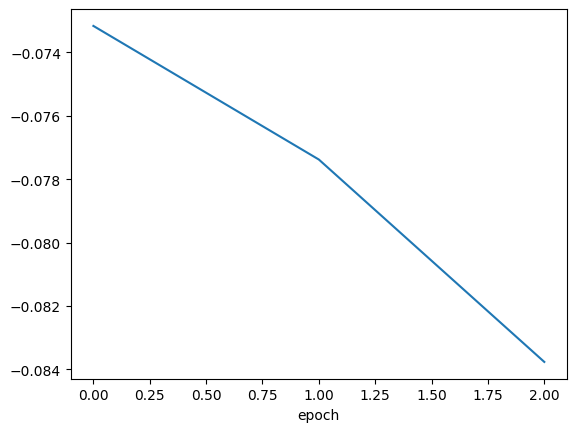

In [ ]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [ ]:
loaded_network = torch.load('models/2025-04-08 12-39-09/model_00__-0.1890.pth', weights_only=False)

In [ ]:
network = network.eval()

In [ ]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    'network': network
}

In [ ]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [ ]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics,
                                       device='cuda')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (224x60 and 150x960)

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

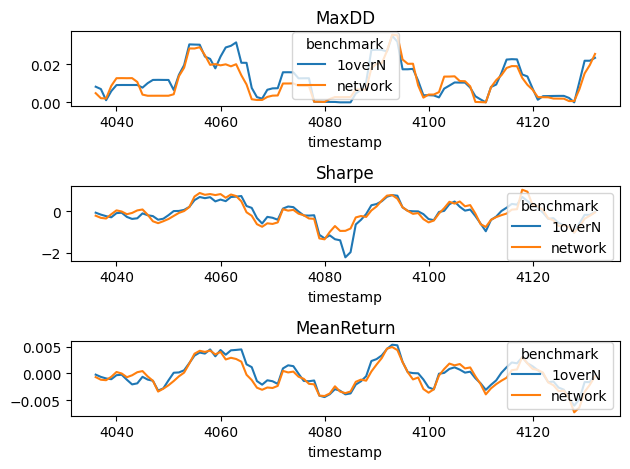

In [ ]:
plot_metrics(metrics_table)

In [ ]:
weight_table = generate_weights_table(network, dataloader_test,device = device)

<Axes: >

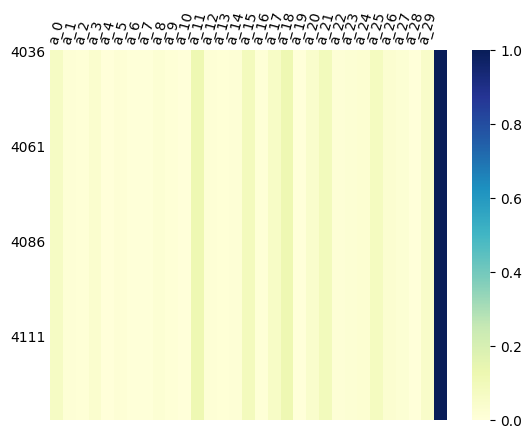

In [ ]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)